#Linear regression in PyTorch

In [ ]:
X=torch.arange(-3, 3, 0.1).reshape(-1, 1)


To keep things simple, we will construct an artificial dataset
according to a linear model with additive noise.
Our task will be to recover this model's parameters
using the finite set of examples contained in our dataset.
We will keep the data low-dimensional so we can visualize it easily.
In the following code, we generate a dataset
containing $1000$ examples, each consisting of $2$ features
sampled from a standard normal distribution.
Thus, our synthetic dataset will be a matrix
$\boldsymbol{X}\in \mathbb{R}^{1000 \times 2}$.

The true parameters generating our dataset will be
$\boldsymbol{w} = [2, -3.4]^\top$ and $b = 4.2$,
and our synthetic labels will be assigned according
to the following linear model with the noise term $\epsilon$:

$$\boldsymbol{y}= \boldsymbol{X} \boldsymbol{w} + b + \epsilon.$$

We can think of $\epsilon$ as capturing potential
measurement errors on the features and labels.
We will assume that the standard assumptions hold, and thus
that $\epsilon$ obeys a normal distribution with mean of $0$.
To make our problem easy, we will set its standard deviation to $0.01$.
The following code generates our synthetic dataset.

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

In [ ]:
def synthetic_data(w, b, num_examples):  
    """Generate y = Xw + b + noise."""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = X @ w + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape(-1, 1)

In [ ]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

Note that each row in `features` consists of a $2$-dimensional data example,
and that each row in `labels` consists of a $1$-dimensional label value (a scalar).

In [ ]:
print('Features:', features[0], '\nLabel:', labels[0])

Features: tensor([1.9269, 1.4873]) 
Label: tensor([2.9871])


By generating a scatter plot using the second feature `features[:, 1]` and `labels`,
we can clearly observe the linear correlation between the two.

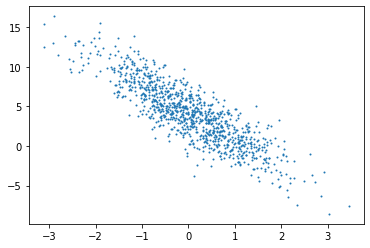

In [ ]:
plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), s=1)
plt.show()

Recall that training models consists of
making multiple passes over the dataset,
fetching one mini-batch of examples at a time,
and using them to update our model.
Since this process is so fundamental
to training machine learning algorithms,
it is worth defining a utility function
to shuffle the dataset and access it in mini-batches.

In the following code, we define the `data_iter` function to demonstrate one possible implementation of this functionality.
The function takes a batch size, a matrix of features,
and a vector of labels, yielding mini-batches of the size `batch_size`.
Each mini-batch consists of a tuple of features and labels.

In [ ]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # The examples are read at random, in no particular order
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In general, note that we want to use reasonably sized mini-batches
to take advantage of the GPU hardware,
which excels at parallelizing operations.
Because each example can be fed through our models in parallel,
and the gradient of the loss function for each example can also be taken in parallel,
GPUs allow us to process hundreds of examples in just little more time
than it might take to process a single example.

To build some intuition, let us read and print
the first small batch of data examples.
The shape of the features in each mini-batch tells us
both the mini-batch size and the number of input features.
Likewise, our mini-batch of labels will have a shape given by `batch_size`.


In [ ]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.1862, -1.2203],
        [ 0.1828,  0.6247],
        [ 0.3726, -1.9105],
        [ 1.2215, -0.3137],
        [ 0.2240, -0.7555],
        [ 0.3267, -0.8344],
        [-0.7585,  0.9420],
        [-1.5785,  0.6716],
        [ 0.9475,  0.4364],
        [-1.3793,  0.6258]]) 
 tensor([[10.7316],
        [ 2.4343],
        [11.4371],
        [ 7.7038],
        [ 7.2027],
        [ 7.7014],
        [-0.5214],
        [-1.2277],
        [ 4.6104],
        [-0.7060]])


As we run the iteration, we obtain distinct mini-batches
successively, until the entire dataset has been exhausted.
While the iteration implemented above is good for didactic purposes,
it is inefficient in ways that might get us in trouble on real problems.
For example, it requires that we load all the data in memory
and that we perform many random memory access.
The built-in iterators implemented in a deep learning framework
are considerably more efficient, and they can deal
with both data stored in files and data fed via data streams.

Rather writing our own iterator,
we can call upon the existing API in PyTorch to read the data. We pass in `features` and `labels` as arguments, and specify `batch_size`
when instantiating a data iterator object.
Besides, the boolean value `is_train`
indicates whether or not
we want the data iterator object to shuffle the data
on each epoch (pass through the dataset).

In [ ]:
def load_array(data_arrays, batch_size, is_train=True): 
    """Construct a PyTorch data iterator."""
    dataset = torch.utils.data.TensorDataset(*data_arrays)
    return torch.utils.data.DataLoader(dataset, batch_size, shuffle=is_train)

In [ ]:
batch_size = 10
data_iter = load_array((features, labels), batch_size)

Now, we can use `data_iter` in much the same way as we called
the `data_iter()` function above.
To verify that it is working, we can read and print
the first mini-batch of examples.
Comparing with the `data_iter()` function,
here we use `iter()` to construct a Python iterator, and use `next()` to obtain the first item from the iterator.

In [ ]:
next(iter(data_iter))

[tensor([[-1.0838, -0.3889],
         [ 0.3267, -0.8344],
         [ 1.5921, -0.4162],
         [ 1.7685, -0.9858],
         [ 1.9138,  0.3378],
         [ 1.2358, -2.0371],
         [ 0.3120,  0.7174],
         [ 0.0879, -1.2415],
         [-0.7150, -0.0476],
         [ 0.6719,  0.9852]]), tensor([[ 3.3636],
         [ 7.7014],
         [ 8.8059],
         [11.0980],
         [ 6.8769],
         [13.5980],
         [ 2.3910],
         [ 8.5881],
         [ 2.9337],
         [ 2.2025]])]

In order to implement **linear regression**, we can use PyTorch's predefined layers, which allow us to focus especially
on the layers used to construct the model,
rather than having to focus on the implementation.
We will first define a model variable `net`,
which will refer to an instance of the `nn.Sequential` class.
The `nn.Sequential` class defines a container
for several layers that will be chained together.
Given input data, a `nn.Sequential` instance passes it through
the first layer, in turn passing the output
as the second layer's input, and so forth.
In the following example, our model consists of only one layer,
so we do not really need `nn.Sequential`.
But, since nearly all of our future models
will involve multiple layers,
we will use it anyway, just to get familiarized with the most standard workflow.

Recall that we redefined linear regression as a single-layer neural network.
The layer is said to be *fully-connected*,
because each of its inputs is connected to each of its outputs
by means of a matrix-vector multiplication.

In PyTorch, the fully-connected layer is defined in the `nn.Linear` class. Note that we pass two arguments into `nn.Linear`. The first one specifies the input feature dimension, which is $2$, and the second one is the output feature dimension, which is a single scalar, and therefore $1$.

In [ ]:
# `nn` is an abbreviation for neural networks
from torch import nn

net = nn.Sequential(nn.Linear(2, 1))

Before using `net`, we need to initialize the model parameters,
such as the weights and bias in the linear regression model.
Deep learning frameworks often have a predefined way to initialize the parameters.
Here, we specify that each weight parameter
should be randomly sampled from a normal distribution
with mean $0$ and standard deviation $0.01$.
The bias parameter will be initialized to $0$.

As we have specified the input and output dimensions when constructing `nn.Linear`,
now we can access the parameters directly, to specify their initial values.
We first locate the layer by `net[0]`, which is the first layer in the network,
and then use the `weight.data` and `bias.data` attributes to access the parameters.
Next, we use the replace methods `normal_()` and `fill_()` to overwrite parameter values. In PyTorch, methods that end with `_` do the corresponding operation in place.

In [ ]:
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

The `nn.MSELoss` class computes the *mean squared error* (without the $1/2$ factor).
By default, it returns the average loss over examples.


In [ ]:
loss = nn.MSELoss()

Mini-batch stochastic gradient descent is a standard tool
for optimizing neural networks,
and thus PyTorch supports it, alongside a number of
variations of this algorithm, in the `optim` module.
When we instantiate an `SGD` instance, we will specify the parameters to optimize over
(obtainable from our `net` via `net.parameters()`), with a dictionary of hyperparameters
required by our optimization algorithm.
Mini-batch stochastic gradient descent just requires that
we set the value `lr`, which is set to $0.03$ here.

In [ ]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.03)

Expressing our model through
high-level APIs of a deep learning framework
requires relatively few lines of code.
We do not have to individually allocate parameters,
define our loss function, or implement mini-batch stochastic gradient descent.
Once we start working with much more complex models,
advantages of high-level APIs will grow considerably.

Now, all we have left to do is define the training loop: for some number of epochs,
we will make a complete pass over the dataset (`data_iter`),
iteratively fetching one mini-batch of inputs
and the corresponding ground-truth labels.
For each mini-batch, we go through the following steps:

* Generate predictions by calling `net(X)` and calculate the loss `l` between the predictions and the labels `y` (the *forward propagation*).
* Calculate gradients by running the *backpropagation*, using the `backward()` function on the loss. To prevent PyTorch from accumulating gradients, which it does by default, we have to call the `zero_grad()` function on the optimizer, before the call to `backward()`.
* Update the model parameters by invoking our *optimizer*, using the `step()` function on the optimizer.

We compute the loss after each epoch and print it to monitor progress.

In [ ]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    l = loss(net(features), labels)
    print(f'Epoch {epoch + 1}, Loss {l:f}')

Epoch 1, Loss 0.000353
Epoch 2, Loss 0.000103
Epoch 3, Loss 0.000101


Below, we compare the model parameters learned by training on finite data
and the actual parameters that generated our dataset.
To access parameters,
we first access the layer that we need from `net`,
and then access that layer's weights and bias.
Note that our estimated parameters are
close to their ground-truth counterparts.


In [ ]:
w = net[0].weight.data
print('Error in estimating w:', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('Error in estimating b:', true_b - b)

Error in estimating w: tensor([-0.0002,  0.0008])
Error in estimating b: tensor([-0.0007])


#The FashionMNIST dataset

One of the most widely used datasets for image classification is the  MNIST dataset.
While it had a good history as a benchmark dataset,
even simple models by today's standards achieve classification accuracy over $95\%$ on it,
making it unsuitable for distinguishing between stronger models and weaker ones.
Today, MNIST serves as more of a sanity check than as a benchmark.
Thus, we will focus our discussion in the following
on the qualitatively similar, but comparatively more complex Fashion-MNIST
dataset, which was released in 2017.

We can download and read the Fashion-MNIST dataset into memory via the build-in functions in PyTorch.

In [ ]:
import torchvision
from torchvision import transforms

# `ToTensor()` converts the image data from PIL type to 32-bit floating point
# tensors. It also divides all numbers by 255, so that all pixel values are between
# 0 and 1
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



Fashion-MNIST consists of images from $10$ categories, each represented
by $6000$ images in the training dataset and by $1000$ in the test dataset.
The *test dataset* (or *test set*) is used for evaluating  model performance and not for training.
Consequently, the training set and the test set
contain $60000$ and $10000$ images, respectively.

In [ ]:
len(mnist_train), len(mnist_test)

(60000, 10000)

The height and width of each input image are both $28$ pixels.
Note that the dataset consists of grayscale images, whose number of channels is $1$.
For brevity, we store the shape of any image with a height of $h$ pixels and a width of $w$ pixels as $h \times w$ or ($h$, $w$).

In [ ]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

The images in Fashion-MNIST are associated with the following categories:
t-shirt, trousers, pullover, dress, coat, sandal, shirt, sneaker, bag, and ankle boot.
The following function converts between numeric label indices and their names in text.

In [ ]:
def get_fashion_mnist_labels(labels):
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

We can now create a function to visualize these examples.

In [ ]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    plt.tight_layout()
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

Here are the images and their corresponding labels (in text)
for the first few examples in the training dataset.

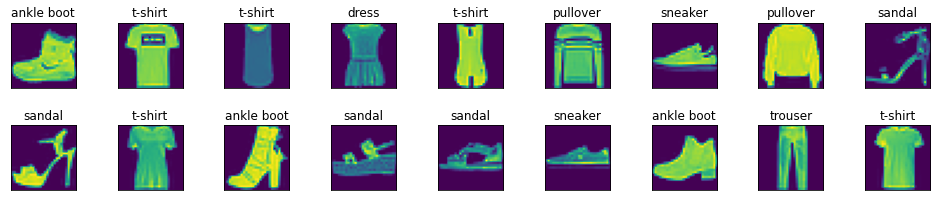

In [ ]:
X, y = next(iter(torch.utils.data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

To make our life easier when reading from the training and test sets,
we use the built-in data iterator, rather than creating one from scratch.
Recall that, at each iteration, a data iterator
reads a mini-batch of data with size `batch_size` each time.
We also randomly shuffle the examples for the training data iterator.

In [ ]:
batch_size = 256

# Use 2 processes to read the data.
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=2)

Now we define the `load_data_fashion_mnist()` function
that obtains and reads the Fashion-MNIST dataset.
It returns the data iterators for the training set, the validation set, and the test set. It uses the `random_split()` method to split the initial training set into the actual training set, having `50000` instances, and the validation set, having the remaining `10000` instances. In order to ensure reproducibility, we also specify a generator with a fixed seed. In addition, the `load_data_fashion_mnist()` function accepts an optional argument to resize images to another shape.

In [ ]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000],
                                                           generator=torch.Generator().manual_seed(42))
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_val, batch_size, shuffle=False,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

Below, we test the image resizing feature of the `load_data_fashion_mnist()` function
by specifying the `resize` argument.

In [ ]:
train_iter, val_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


We are now ready to work with the Fashion-MNIST dataset.

#Softmax regression in PyTorch

Next, we will implement **softmax regression** in PyTorch. We will work with the Fashion-MNIST dataset, setting up data iterators with batch size $256$.

In [ ]:
batch_size = 256
train_iter, val_iter, test_iter = load_data_fashion_mnist(batch_size)

As for linear regression,
each example here will be represented by a fixed-length vector.
Each example in the raw dataset is a $28 \times 28$ image.
Here, we will flatten each image,
treating them as vectors of length $784$.
Thus, we treat each pixel location as just another feature.

Recall that, in softmax regression,
we have as many outputs as there are classes.
Because our dataset has $10$ classes,
our network will have an output dimension of $10$.
Consequently, our weights will constitute a $784 \times 10$ matrix,
and the biases will constitute a $1 \times 10$ row vector.

Recall also that the output layer of softmax regression
is a fully-connected layer. Therefore, to implement our model,
we just need to add one fully-connected layer
with $10$ outputs to a `nn.Sequential` class.
Because the inputs are given in the dataset as a $3$-dimensional tensor, we have to reshape them to a $2$-dimensional tensor, which is the only type of tensor fully-connected layers can manipulate. We do this by adding the `nn.Flatten` layer before the fully-connected layer. 

Again, we initialize the weights at random
with zero mean and standard deviation $0.01$.

In [ ]:
# PyTorch does not implicitly reshape the inputs. Thus, we define the flatten
# layer to reshape the inputs before the linear layer in our network.
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

Notice that we do not add a softmax layer to our network. In PyTorch, instead of passing softmax probabilities into the loss function, we will just
pass the logits, and compute the softmax and its logarithm
all at once inside the *cross-entropy loss* function,
which uses different computational tricks to avoid numerical instability issues.

In [ ]:
loss = nn.CrossEntropyLoss()

Here, we use mini-batch stochastic gradient descent
with a learning rate of $0.1$ as the optimization algorithm.
Note that this is the same as we applied in the linear regression example,
and it illustrates the general applicability of the optimizers.

In [ ]:
lr = 0.1
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

Given the predicted probability distribution `y_hat`,
we typically choose the class with the highest predicted probability,
whenever we must output a hard prediction.
Indeed, many applications require that we make a choice.
Gmail must categorize an email into "Primary", "Social", "Updates", or "Forums".
It might estimate probabilities internally,
but, at the end of the day, it has to choose one among the classes.

When predictions are consistent with the label class `y`, they are correct.
The classification accuracy is the fraction of all predictions that are correct.
Although it can be difficult to optimize accuracy directly (it is not differentiable),
it is often the performance measure that we care most about,
and we will nearly always report it when training classifiers.

To compute accuracy we do the following.
First, if `y_hat` is a matrix,
we assume that the second dimension stores prediction scores for each class.
We use `argmax()` to obtain the predicted class by the index for the largest entry in each row.
Then, we compare the predicted class with the ground-truth `y` elementwise.
Since the equality operator `==` is sensitive to data types,
we convert `y_hat`'s data type to match that of `y`.
The result is a tensor containing entries of $0$ (false) and $1$ (true).
Taking the sum yields the number of correct predictions. We can evaluate the accuracy for any model `net` on a dataset that is accessed via the data iterator `data_iter`. We use the variables `total_hits` and `total_samples` for storing the number of correct predictions and the number of predictions, respectively. Both will be accumulated over time as we iterate over the dataset. We also accumulate the total loss in the `total_loss` variable, and we return the mean loss by dividing by the number of batches `len(data_iter)`, because each individual loss is computed batchwise.

In [ ]:
def evaluate_accuracy(net, data_iter):
    """Compute the accuracy for a model on a dataset."""
    net.eval()  # Set the model to evaluation mode

    total_loss = 0
    total_hits = 0
    total_samples = 0
    with torch.no_grad():
        for X, y in data_iter:
            y_hat = net(X)
            l = loss(y_hat, y)
            total_loss += float(l)
            total_hits += sum(net(X).argmax(axis=1).type(y.dtype) == y)
            total_samples += y.numel()
    return float(total_loss) / len(data_iter), float(total_hits) / total_samples  * 100

The training loop for softmax regression should look strikingly familiar,
if we read through our implementation
of linear regression.
Here, we refactor the implementation to make it reusable.
First, we define a function to train for one epoch.
Note that `optimizer` is a general function to update the model parameters,
which accepts the batch size as an argument.
It will be one of the framework's built-in optimization functions.

In [ ]:
def train_epoch(net, train_iter, loss, optimizer):  
    # Set the model to training mode
    net.train()
    # Sum of training loss, sum of training correct predictions, no. of examples
    total_loss = 0
    total_hits = 0
    total_samples = 0
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        # Using PyTorch built-in optimizer & loss criterion
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        total_loss += float(l)
        total_hits += sum(y_hat.argmax(axis=1).type(y.dtype) == y)
        total_samples += y.numel()
    # Return training loss and training accuracy
    return float(total_loss) / len(train_iter), float(total_hits) / total_samples  * 100

The following training function then
trains a model `net` on a training dataset accessed via `train_iter`
for multiple epochs, which is specified by `num_epochs`.
At the end of each epoch,
the model is evaluated on a validation dataset, accessed via `val_iter`.

In [ ]:
def train(net, train_iter, val_iter, loss, num_epochs, optimizer):
    """Train a model."""
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(net, train_iter, loss, optimizer)
        train_loss_all.append(train_loss)
        train_acc_all.append(train_acc)
        val_loss, val_acc = evaluate_accuracy(net, val_iter)
        val_loss_all.append(val_loss)
        val_acc_all.append(val_acc)
        print(f'Epoch {epoch + 1}, Train loss {train_loss:.2f}, Train accuracy {train_acc:.2f}, Validation loss {val_loss:.2f}, Validation accuracy {val_acc:.2f}')

    return train_loss_all, train_acc_all, val_loss_all, val_acc_all

Now, we train the model for $10$ epochs.
Note that both the number of epochs (`num_epochs`),
and learning rate (`lr`) are adjustable hyperparameters.
By changing their values, we may be able
to increase the classification accuracy of the model.

In [ ]:
num_epochs = 10
train_loss_all, train_acc_all, val_loss_all, val_acc_all = train(net, train_iter, val_iter, loss, num_epochs, optimizer)

Epoch 1, Train loss 0.82, Train accuracy 73.86, Validation loss 0.63, Validation accuracy 78.73
Epoch 2, Train loss 0.58, Train accuracy 80.99, Validation loss 0.57, Validation accuracy 81.14
Epoch 3, Train loss 0.54, Train accuracy 82.23, Validation loss 0.53, Validation accuracy 82.20
Epoch 4, Train loss 0.51, Train accuracy 82.91, Validation loss 0.52, Validation accuracy 82.29
Epoch 5, Train loss 0.49, Train accuracy 83.39, Validation loss 0.51, Validation accuracy 82.79
Epoch 6, Train loss 0.48, Train accuracy 83.79, Validation loss 0.49, Validation accuracy 83.34
Epoch 7, Train loss 0.47, Train accuracy 84.01, Validation loss 0.51, Validation accuracy 82.04
Epoch 8, Train loss 0.46, Train accuracy 84.24, Validation loss 0.47, Validation accuracy 83.80
Epoch 9, Train loss 0.46, Train accuracy 84.63, Validation loss 0.49, Validation accuracy 83.52
Epoch 10, Train loss 0.45, Train accuracy 84.59, Validation loss 0.53, Validation accuracy 80.71


We separately plot the loss and the accuracy for the training and validation sets, using the `plot_loss()` and `plot_accuracy()` methods, respectively.

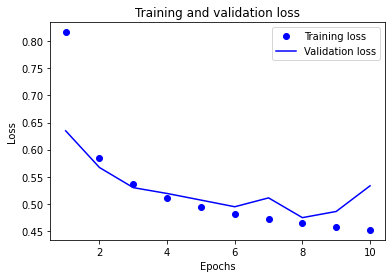

In [ ]:
def plot_loss(train_loss_all, val_loss_all):
    epochs = range(1, len(train_loss_all) + 1) 
    plt.plot(epochs, train_loss_all, 'bo', label='Training loss') 
    plt.plot(epochs, val_loss_all, 'b', label='Validation loss') 
    plt.title('Training and validation loss') 
    plt.xlabel('Epochs') 
    plt.ylabel('Loss') 
    plt.legend()  
    plt.show()

plot_loss(train_loss_all, val_loss_all)

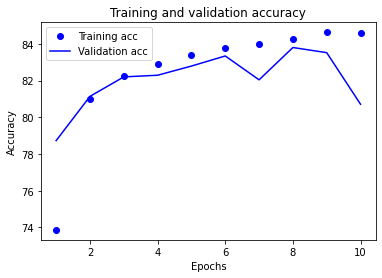

In [ ]:
def plot_accuracy(train_acc_all, val_acc_all):
    epochs = range(1, len(train_acc_all) + 1)
    plt.plot(epochs, train_acc_all, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_all, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs') 
    plt.ylabel('Accuracy') 
    plt.legend()
    plt.show()

plot_accuracy(train_acc_all, val_acc_all)

Now that training is complete, we can evaluate the trained model on the *test set*, which was not used at all during the training process, not even for choosing hyperparameters.

In [ ]:
test_loss, test_acc = evaluate_accuracy(net, test_iter)
print(f'Test loss {test_loss:.2f}, Test accuracy {test_acc:.2f}')

Test loss 0.55, Test accuracy 80.06


We can also use our model to classify some images.
Given a series of images,
we will compare their actual labels
(first line of text output)
and the predictions from the model
(second line of text output).

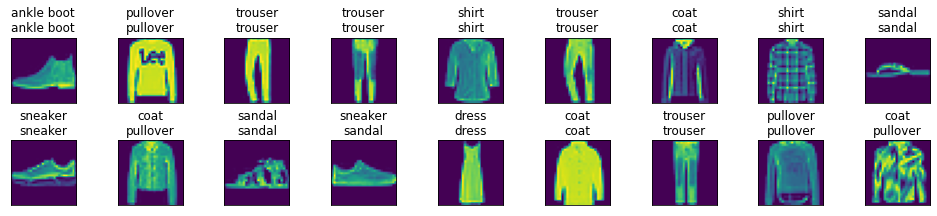

In [ ]:
def predict(net, test_iter, n=18):
    """Predict labels."""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape((n, 28, 28)), 2, int(n/2), titles=titles[0:n])

predict(net, test_iter)

In short, as long as all data and parameters are on the same device, we can learn models efficiently.